# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('./data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network

In [3]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        # print(input_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        # print(x.shape)
        # print(c_n.shape, h_n.shape, x.shape)
        out = (self.linear(out[-1]))
        # print(x[-1].shape)
        out = self.softmax(out)
        return out

n_hidden = 128
rnn = LSTM(n_letters, n_hidden, n_categories)
print(rnn)

LSTM(
  (lstm): LSTM(57, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [4]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

We will also want a quick way to get a training example (a name and its language):

In [5]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Vysokin
category = Portuguese / line = Gouveia
category = Portuguese / line = Ferreira
category = Korean / line = Sung
category = Greek / line = Protopsaltis
category = Chinese / line = Yan
category = Korean / line = Si
category = Czech / line = Toman
category = Japanese / line = Taketomo
category = Vietnamese / line = Mach


### Training the Network

In [6]:
learning_rate = 0.08
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [7]:
def train(category_tensor, line_tensor):
    optimizer.zero_grad()
    output = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
current_acc = 0
all_losses = []
all_accs = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    guess, _ = categoryFromOutput(output)
    if guess == category:
        current_acc += 1
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accs.append(current_acc / plot_every)
        current_loss = 0
        current_acc = 0

5000 5% (0m 19s) 1.2786 Hung / Chinese ✗ (Korean)
10000 10% (0m 39s) 2.1845 Scolaidhe / French ✗ (Irish)
15000 15% (0m 59s) 2.4274 Jang / Chinese ✗ (Korean)
20000 20% (1m 21s) 1.0821 Rusnak / Czech ✗ (Polish)
25000 25% (1m 41s) 1.1833 Best / German ✓
30000 30% (2m 1s) 1.1170 Sai / Chinese ✗ (Vietnamese)
35000 35% (2m 20s) 0.0006 Mitzusaka / Japanese ✓
40000 40% (2m 42s) 1.2374 Nicastro / Spanish ✗ (Italian)
45000 45% (3m 3s) 0.6707 Mullins / French ✓
50000 50% (3m 22s) 0.0823 Loh / Chinese ✓
55000 55% (3m 42s) 0.0054 Hitomi / Japanese ✓
60000 60% (4m 1s) 0.6728 Rim / Korean ✓
65000 65% (4m 20s) 1.9847 Carideo / Spanish ✗ (Italian)
70000 70% (4m 39s) 0.1057 Romao / Portuguese ✓
75000 75% (4m 58s) 2.7162 Leck / Czech ✗ (English)
80000 80% (5m 20s) 0.1659 Schult / German ✓
85000 85% (5m 43s) 0.0007 Accursio / Italian ✓
90000 90% (6m 4s) 0.0736 Kaczka / Polish ✓
95000 95% (6m 26s) 0.0091 Simoes / Portuguese ✓
100000 100% (6m 47s) 0.0063 Albuquerque / Portuguese ✓


### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

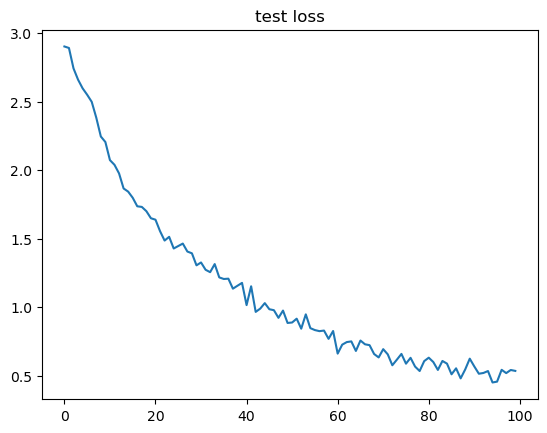

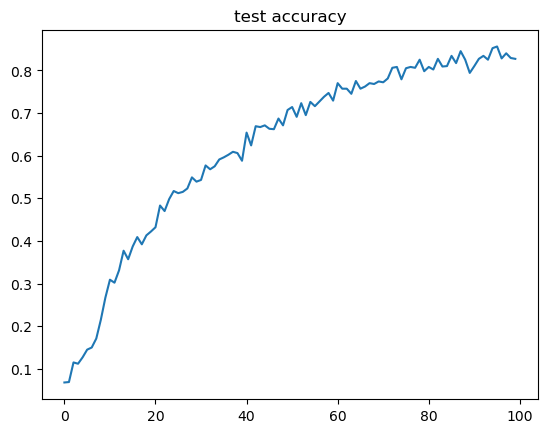

In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.title('test loss');

plt.figure()
plt.plot(all_accs)
plt.title('test accuracy');

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13652\3715091559.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13652\3715091559.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


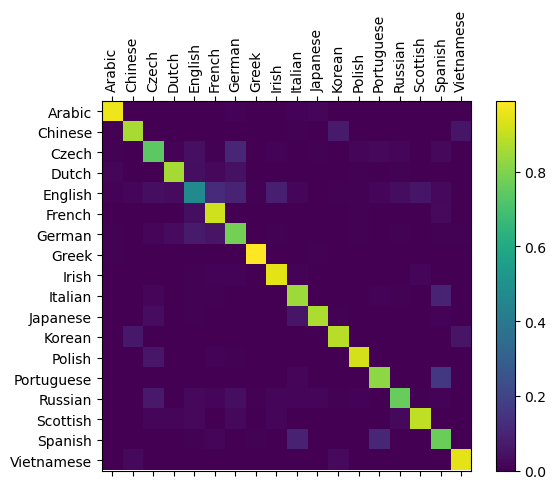

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    return rnn(line_tensor)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).